In [1]:
%reload_ext autoreload
%autoreload 2

import time
from pathlib import Path
from copy import copy, deepcopy
import random
import numpy as np
import scipy as sp
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import utils
from dominoes import fileManagement as fm
from dominoes import transformers
from dominoes import datasets
from dominoes import training
from dominoes.analysis import transformer_analysis as ta
from dominoes import utils

device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [8]:
"""
Dominoes tasks:
1. Plot valueAgentELO results effectively, document it
2. Train a library of lineValueAgents on a server
3. Build a policy-only agent
   - learn network approximation of value function same way other agents do
   - process hand and game state to generate a context embedding
   - then use pointer networks to choose which option to play based on the option encoding and the context
   - policy updated with temporal-difference of the value function
4. Build a win-probability agent method (to be applied to all agents) 
   - I think this is going to involve a bit of cleaning and refactoring of my agents code

Dominoes Experiments:
1. Compare lineValueNetwork trained on only it's turn vs. all turns. vs. it's turn and next turn
2. Compare value agents trained with hand-continuity of eligibility traces or resets

Dominoes Analysis Goals:
1. Study some of the key layers of agent value networks!
2. Initialize the game many times and correalte lineValueFeatures with final score output

Dominoes Coding Practice:
1. Still need to refactor some of the "experiment" scripts to make sure they divide results and plotting 
"""


"""
Pointer Immediate Tasks:
1. Use a separate value network to force encoding to predict the total rewards of the pointer output
2. Run an experiment where I take trained pointer networks and transition them to a dominoe based value 
function and a gamma < 1, and show that they can learn to prioritize playing high value dominoes first. Then...
3. Add the context vector that encodes the number of turns left (with uncertainty?)
    - so the full pointer network will get an extra context input that describes how many turns are left
    - 0 rewards will be given after the possible turns are over
    - so the network will have to learn to get as much value out as quickly as possible
4. Also apply these networks to the vehicle routing problem?
5. Analyze encoding space of pointer networks...
6. Do the encoder swap of different pointer layers...

Pointer Big Ideas:
1. Develop new tasks based on graphs, random forests, and complex rules and determine whether the sophisticated 
pointer layer architecture works better on them. 

Pointer Coding Practice:
1. Convert reward functions to a class 
2. Convert dataset preparation to a class

Pointer Mechanical Update:
1. Change it to learn an initial decoder to be used whenever an input position isn't provided! 
   - self.custom_tensor = nn.Parameter(torch.randn(input_size, output_size), requires_grad=True)
"""

# RERUN POINTER SEQUENCER WITH BASELINE MODE!!!
# RERUN POINTER SEQUENCER RL with Temperature = 5.0 (it was set to 1.0 for the first training...)

# THE CODE IS PRETTY UNORGANIZED :(
   # update pointer network to have a separate "encoder" module and a "decoder" module (then I can reuse and redeploy the encoder module in different kinds of networks)
   # need to have a dev branch and keep the main nice and tidy
   # need to organize the dominoes agents better (especially with regards to whether they predict their final score or the win probability)

'\nPointer Immediate Tasks:\n1. Use a separate value network to force encoding to predict the total rewards of the pointer output\n2. Run an experiment where I take trained pointer networks and transition them to a dominoe based value \nfunction and a gamma < 1, and show that they can learn to prioritize playing high value dominoes first. Then...\n3. Add the context vector that encodes the number of turns left (with uncertainty?)\n    - so the full pointer network will get an extra context input that describes how many turns are left\n    - 0 rewards will be given after the possible turns are over\n    - so the network will have to learn to get as much value out as quickly as possible\n4. Also apply these networks to the vehicle routing problem?\n\nPointer Big Ideas:\n1. Develop new tasks based on graphs, random forests, and complex rules and determine whether the sophisticated \npointer layer architecture works better on them. \n\nPointer Coding Practice:\n1. Convert reward functions 

In [2]:
POINTER_METHODS = ['PointerStandard', 'PointerDot', 'PointerDotLean', 'PointerDotNoLN', 'PointerAttention', 'PointerTransformer']
numNets = len(POINTER_METHODS)

def getFileName(extra=None):
    baseName = "pointerArchitectureComparison"
    if extra is not None:
        baseName = baseName + f"_{extra}"
    return baseName

results, args = utils.loadSavedExperiment(fm.prmPath(), fm.resPath(), getFileName())
nets = [torch.load(fm.netPath() / getFileName(extra=f"{method}.pt")) for method in POINTER_METHODS]

In [84]:
def getRank(data):
    values = -np.unique(np.sort(-data))
    rank = np.array([{val: idx for idx, val in enumerate(values)}[d] for d in data])
    return rank

def getPaired(data, compress=True):
    assert data.ndim==1, "data must be 1d"
    num_elements = data.shape[0]
    square_data = data.reshape(num_elements, 1).repeat(num_elements, axis=1)
    if compress:
        return np.stack((sp.spatial.distance.squareform(square_data, checks=False),
                         sp.spatial.distance.squareform(square_data.T, checks=False)), axis=1)
    else:
        return np.stack((square_data, square_data.T), axis=2)

with torch.no_grad():
    # make sure everything is on the same device
    nets = [net.to(device) for net in nets]

    # get a "normal" batch
    highestDominoe = args.highest_dominoe
    listDominoes = df.listDominoes(highestDominoe)

    # do subselection for training
    doubleDominoes = listDominoes[:,0] == listDominoes[:,1]
    nonDoubleReverse = listDominoes[~doubleDominoes][:,[1,0]] # represent each dominoe in both orders

    # list of full set of dominoe representations and value of each
    listDominoes = np.concatenate((listDominoes, nonDoubleReverse), axis=0)
    rankDominoes = getRank(np.sum(listDominoes, axis=1))
    dominoeValue = np.sum(listDominoes, axis=1)

    # training inputs
    numDominoes = len(listDominoes)
    dominoeValue = np.sum(listDominoes, axis=1)
    batchSize = 1024 # lots of data!
    handSize = args.hand_size
    numElements = batchSize * handSize
    batch_inputs = dict(
        null_token=False, 
        available_token=False, 
        ignore_index=- 1, 
        return_full=True,
        return_target=False
    )

    selection = np.array([])
    while len(np.unique(selection))!=numDominoes:
        batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, **batch_inputs)
        
        # unpack batch tuple
        input, _, _, _, _, selection, _ = batch
        input = input.to(device)

    # value of input data
    value = np.sum(listDominoes[selection], axis=2)
    rank = np.stack([getRank(val) for val in value])

    # get standard network output
    scores, choices = map(list, zip(*[net(input, max_output=handSize) for net in nets]))

    # get rewards
    rewards = [training.measureReward_sortDescend(listDominoes[selection], choice) for choice in choices]
    perfect = [torch.sum(reward, dim=1)==8 for reward in rewards]
    perfect_ext = [prf.view(batchSize, 1).expand(-1, handSize).reshape(numElements) for prf in perfect]
    
    # reshape for convenience    
    scores = [score.view(numElements, handSize) for score in scores]
    choices = [choice.view(numElements) for choice in choices]

    # == do some processing on the shapes of data ==
    selection, value, rank = selection.reshape(numElements), value.reshape(numElements), rank.reshape(numElements)
    overall_rank = rankDominoes[selection]
    oranks = np.unique(overall_rank) # all in overall_rank

    # get paired index, value, and rank
    pidx = getPaired(selection, compress=True)
    pval = getPaired(value, compress=True)
    prnk = getPaired(rank, compress=True)

    
    # == then get hidden activations and process them == 

    # encoding
    embedded = [net.embedding(input) for net in nets]
    encoded = [net.encoding(embed) for net, embed in zip(nets, embedded)]

    # translate to (token x embedding)
    encoded = [encode.view(-1, encode.size(2)).T for encode in encoded]

    # do normalization 
    nencoded = [(encode-encode.mean(1, keepdim=True))/encode.std(1, keepdim=True) for encode in encoded]
        
    # get distance matrix
    dist = [torch.nn.functional.pdist(encode.T).cpu() for encode in nencoded]

    # get covariance
    cov = [torch.cov(encode) for encode in nencoded]

    # get eigenvalues
    eigvals, eigvecs = map(list, zip(*[torch.linalg.eigh(c) for c in cov]))
    eigvals = [eigval.cpu().numpy() for eigval in eigvals]
    eigvecs = [eigvec.cpu().numpy() for eigvec in eigvecs]

    # sort highest to lowest
    idx_sort = [np.argsort(-eigval) for eigval in eigvals]
    eigvals = [eigval[isort] for eigval, isort in zip(eigvals, idx_sort)]
    eigvecs = [eigvec[:,isort] for eigvec, isort in zip(eigvecs, idx_sort)]

    # negative values are numerical errors
    eigvals = [np.maximum(eigval, 0) for eigval in eigvals]

    # create some sorting indices for the embedded dimensions
    idx_max = [torch.argsort(-torch.mean(encode[:, overall_rank==0], dim=1)) for encode in nencoded]
    idx_min = [torch.argsort(torch.mean(encode[:, overall_rank==oranks[-1]], dim=1)) for encode in nencoded]

    # average encoded by overall rank
    encoded_overall_rank = [torch.stack([torch.mean(encode[:,overall_rank==ornk], dim=1) for ornk in oranks], dim=1)
                            for encode in nencoded]
    encoded_overall_rank_var = [torch.stack([torch.var(encode[:, overall_rank==ornk], dim=1) for ornk in oranks], dim=1)
                                for encode in nencoded]

    idx_weighted_rank = [torch.argsort(torch.sum((eor.cpu()-eor.cpu().min(dim=1)[0].view(-1, 1))*torch.tensor(oranks).view(1, -1), dim=1)/np.sum(oranks))
                    for eor in encoded_overall_rank]

    # average encoded by choice position
    encoded_position = [torch.stack([torch.mean(encode[:, choice==pos], dim=1) for pos in range(handSize)], dim=1)
                        for encode, choice in zip(nencoded, choices)] 
    encoded_position_var = [torch.stack([torch.var(encode[:, choice==pos], dim=1) for pos in range(handSize)], dim=1)
                            for encode, choice in zip(nencoded, choices)] 

    idx_weighted_pos = [torch.argsort(torch.sum((ep.cpu()-ep.cpu().min(dim=1)[0].view(-1, 1))*torch.arange(handSize).view(1, -1), dim=1)/torch.sum(torch.arange(handSize)))
                                    for ep in encoded_position]

# Some things to do: 
# - compare how the representation of the maximum value in a dataset looks compared to the maximum dominoe values overall

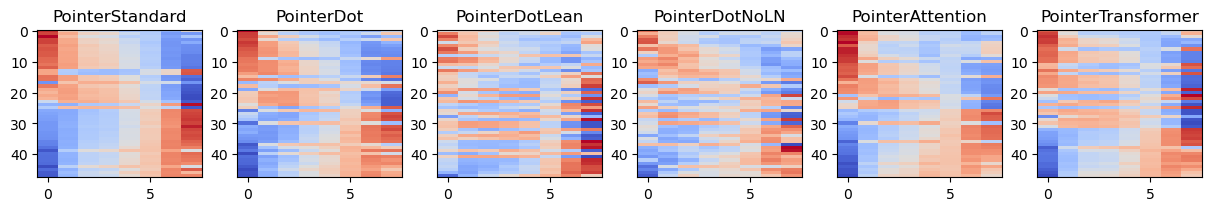

In [85]:
figdim = 2

plt.close('all')
fig, ax = plt.subplots(1, numNets, figsize=(figdim*numNets, 1*figdim), layout='constrained')
for ii, (name, ep, iwp) in enumerate(zip(POINTER_METHODS, encoded_position, idx_weighted_pos)):
    ax[ii].imshow(ep[iwp].cpu().numpy(), aspect='auto', interpolation='none', cmap='coolwarm')
    ax[ii].set_title(name)

plt.show()

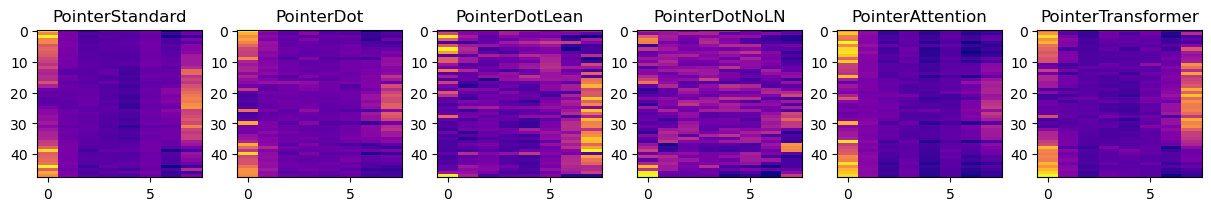

In [86]:
figdim = 2

plt.close('all')
fig, ax = plt.subplots(1, numNets, figsize=(figdim*numNets, 1*figdim), layout='constrained')
for ii, (name, ep, iwp) in enumerate(zip(POINTER_METHODS, encoded_position_var, idx_weighted_pos)):
    ax[ii].imshow(ep[iwp].cpu().numpy(), aspect='auto', interpolation='none', cmap='plasma')
    ax[ii].set_title(name)

plt.show()


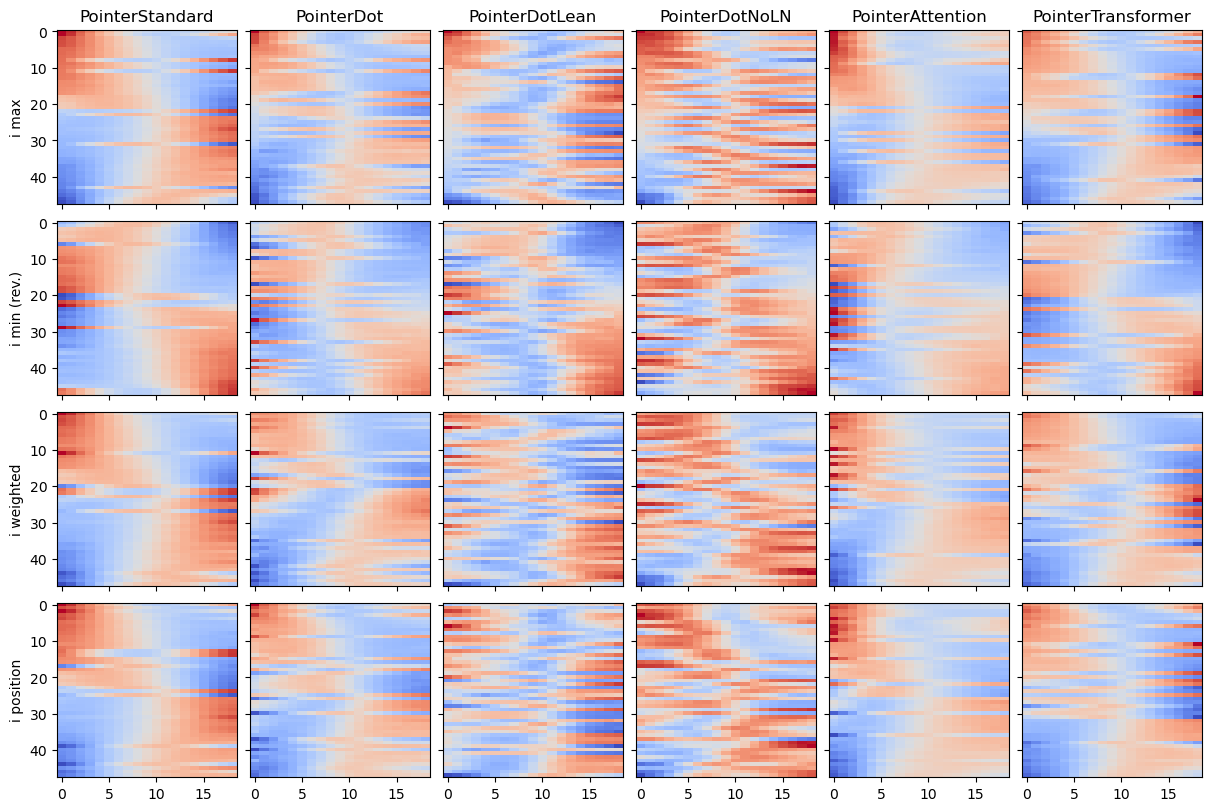

In [87]:
figdim = 2

plt.close('all')
fig, ax = plt.subplots(4, numNets, figsize=(figdim*numNets, 4*figdim), layout='constrained', sharex=True, sharey=True)
for ii, (name, eor, imax, imin, iwgt, ipos) in enumerate(zip(POINTER_METHODS, encoded_overall_rank, idx_max, idx_min, idx_weighted_rank, idx_weighted_pos)):
    ax[0,ii].imshow(eor[imax].cpu().numpy(), aspect='auto', interpolation='none', cmap='coolwarm')
    ax[1,ii].imshow(eor[imin].cpu().numpy(), aspect='auto', interpolation='none', cmap='coolwarm')
    ax[2,ii].imshow(eor[iwgt].cpu().numpy(), aspect='auto', interpolation='none', cmap='coolwarm')
    ax[3,ii].imshow(eor[ipos].cpu().numpy(), aspect='auto', interpolation='none', cmap='coolwarm')
    ax[0,ii].set_title(name)
    if ii==0:
        ax[0,ii].set_ylabel('i max')
        ax[1,ii].set_ylabel('i min (rev.)')
        ax[2,ii].set_ylabel('i weighted')
        ax[3,ii].set_ylabel('i position')
    
plt.show()

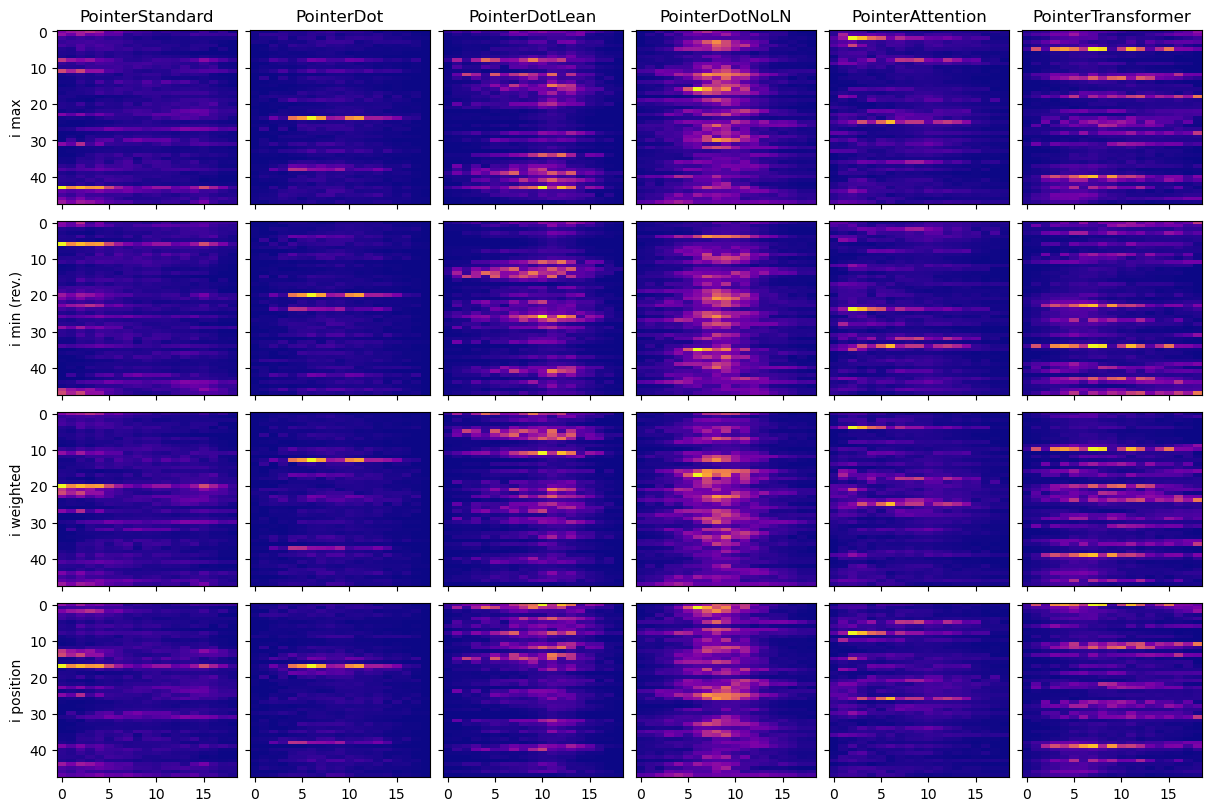

In [88]:
figdim = 2

plt.close('all')
fig, ax = plt.subplots(4, numNets, figsize=(figdim*numNets, 4*figdim), layout='constrained', sharex=True, sharey=True)
for ii, (name, eor, imax, imin, iwgt, ipos) in enumerate(zip(POINTER_METHODS, encoded_overall_rank_var, idx_max, idx_min, idx_weighted_rank, idx_weighted_pos)):
    ax[0,ii].imshow(eor[imax].cpu().numpy(), aspect='auto', interpolation='none', cmap='plasma')
    ax[1,ii].imshow(eor[imin].cpu().numpy(), aspect='auto', interpolation='none', cmap='plasma')
    ax[2,ii].imshow(eor[iwgt].cpu().numpy(), aspect='auto', interpolation='none', cmap='plasma')
    ax[3,ii].imshow(eor[ipos].cpu().numpy(), aspect='auto', interpolation='none', cmap='plasma')
    ax[0,ii].set_title(name)
    if ii==0:
        ax[0,ii].set_ylabel('i max')
        ax[1,ii].set_ylabel('i min (rev.)')
        ax[2,ii].set_ylabel('i weighted')
        ax[3,ii].set_ylabel('i position')
    
plt.show()

In [23]:
from pathlib import Path
pointer_methods = ['PointerStandard', 'PointerDot']

resPath = Path('experiments') / 'savedResults'
savePath = Path('.') / 'experiments' / 'savedNetworks'
results = np.load(resPath / 'pointerArchitectureComparison.npy', allow_pickle=True).item()
nets = []
for pointer_method in pointer_methods:
    name = f"pointerArchitectureComparison_{pointer_method}.pt"
    nets.append(torch.load(savePath / name))
nets = [net.to(device) for net in nets]

In [24]:
outs = ta.processData(nets, 2048)
embedded, encoded, intermediate, decoder_context, decoder_input, scores, choices = outs

In [72]:
# make dominoe x embedding array to figure out sort index for units
emb_dim = ptr_encoded.size(2)
scatter_index = torch.tensor(selection, dtype=torch.long).view(-1,1)
dom_rep_encoded = torch.zeros((numDominoes, emb_dim), dtype=torch.float)
dom_rep_counts = torch.zeros((numDominoes, 1), dtype=torch.long)
dom_rep_encoded.scatter_add_(0, scatter_index.expand(-1, emb_dim), ptr_encoded.view(-1, emb_dim))
dom_rep_counts.scatter_add_(0, scatter_index, torch.ones_like(scatter_index, dtype=torch.long))
dom_rep_encoded /= dom_rep_counts # average encoding of each dominoe

In [83]:
# sort encoding and decodings
proj_value = torch.tensor(dominoeValue, dtype=torch.float) @ dom_rep_encoded
idx_dom_sort = np.argsort(dominoeValue)
idx_enc_sort = torch.argsort(-proj_value)

evals, evecs = torch.linalg.eigh(torch.cov(dom_rep_encoded.T))
idx_evals = torch.argsort(-evals)
evals = evals[idx_evals]
evecs = evecs[:, idx_evals]
idx_pca = torch.argsort(evecs[:,0])

(48, 1)


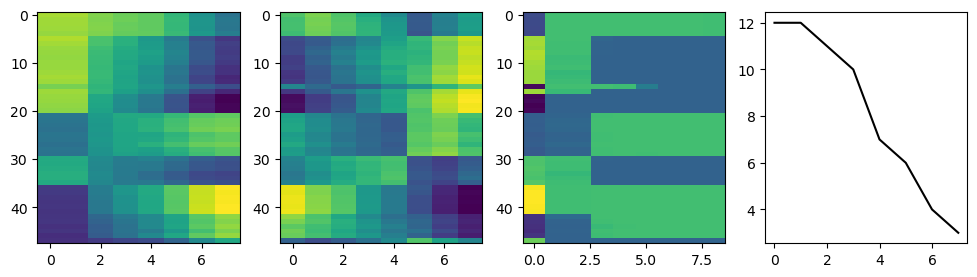

In [74]:
# pick batch index and show data
bidx = 2
batch_dominoes = listDominoes[selection[bidx]]
batch_value = np.sum(batch_dominoes, axis=1)

combined = ptr_encoded[bidx] + ptr_decoded[bidx][:,0]
ctrans = np.tanh(combined.T[idx_enc_sort][:,choices[bidx]].detach().numpy())
vtrans = nets[0].pointer.pointer.vt.weight.detach().cpu().numpy()[0, idx_enc_sort].reshape(-1,1)
print(vtrans.shape)

plt.close('all')
fig, ax = plt.subplots(1,4,figsize=(12,3))
ax[0].imshow(ptr_encoded[bidx].T[idx_enc_sort][:,choices[bidx]].detach().numpy(), aspect='auto')
ax[1].imshow(ptr_decoded[bidx][idx_enc_sort].detach().numpy(), aspect='auto')
ax[2].imshow(np.hstack((vtrans, ctrans)), aspect='auto')
ax[3].plot(range(len(batch_value)), batch_value[choices[bidx]], color='k', label='dominoe value')
plt.show()

torch.Size([512, 8, 48])
torch.Size([512, 8])
torch.Size([512, 48, 8])


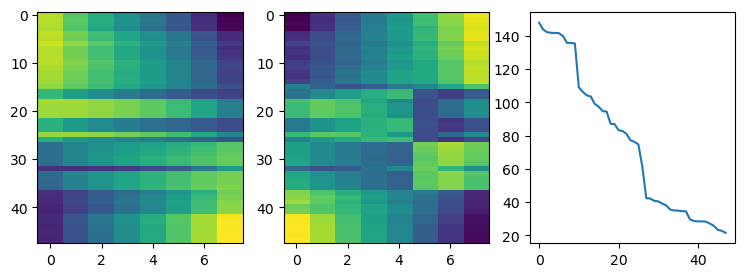

In [84]:
print(ptr_encoded.shape)
print(choices.shape)
print(ptr_decoded.shape)

srt_ptr_encoded = torch.gather(ptr_encoded, 1, choices.unsqueeze(2).expand(-1,-1,ptr_encoded.size(2)))

plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(9,3))
ax[0].imshow(torch.mean(srt_ptr_encoded, axis=0).T[idx_pca].detach().numpy(), aspect='auto')
ax[1].imshow(torch.mean(ptr_decoded, axis=0)[idx_pca].detach().numpy(), aspect='auto')
ax[2].plot(range(ptr_encoded.size(2)), -torch.sort(-torch.var(ptr_encoded, dim=(0,1)))[0].detach().numpy())
plt.show()


In [73]:
# the above is the right idea. need to write good code to:
# -- take a full batch of data (ensuring that each dominoe is represented) and sort activations 
#             - using rastermap, PCA, basic sort projection method
# -- show the encoding of different batches with the decoder dot representation
# -- show the decoder update rules (study the decoder transformer) NOTE THAT THIS IS COMPLICATED!!!
# -- show how encoding of the same dominoe changes depending on what other dominoes are present

In [ ]:
# and need to update interpretability code (immediatley above and in analysis module) to include breakdown of all the pointer_method layers

In [118]:
# first add a plot showing the average encoding and decoding across the different positions
# use above ideas and change the eigenspectrum plots to variance plots for each individual dimension

In [100]:
# I also need to compare the performance with the GRU and LSTM!

In [5]:
# also: I'm preparing a move to a new development branch so I can leave a working system behind. 
# let's clean some things up then do that soon. 

In [23]:
POINTER_METHODS = ta.POINTER_METHODS
net_lookup = {val:idx for idx,val in enumerate(POINTER_METHODS)}
netidx = lambda x: net_lookup[x]

batchSize = 128
num_cities = 8
baseName = "ptrArchComp_TSP_RL"
results, nets = ta.loadNetworks(baseName)
outs = ta.process_tsp_data(nets, batchSize, num_cities)
embedded, encoded, intermediate, decoder_context, decoder_input, scores, choices, batch = outs
_, xy, dists = batch # don't need the input representation

In [88]:
# MDS for embedded vs positions
idx = netidx('PointerDot')
dist_method = ta.torch_pdist
dist_data = dist_method(xy.view(batchSize*num_cities, -1))
dist_embedded = dist_method(embedded[idx].view(batchSize*num_cities, -1))
dist_encoded = dist_method(encoded[idx].view(batchSize*num_cities, -1))

In [97]:
dist_mats = [dist_data, dist_embedded, dist_encoded]
order_data = [ta.compute_serial_matrix(dm.cpu().numpy())[1] for dm in dist_mats]
ser_data = [[ta.seriate_matrix(dm.cpu().numpy(), od) for dm in dist_mats] for od in order_data]


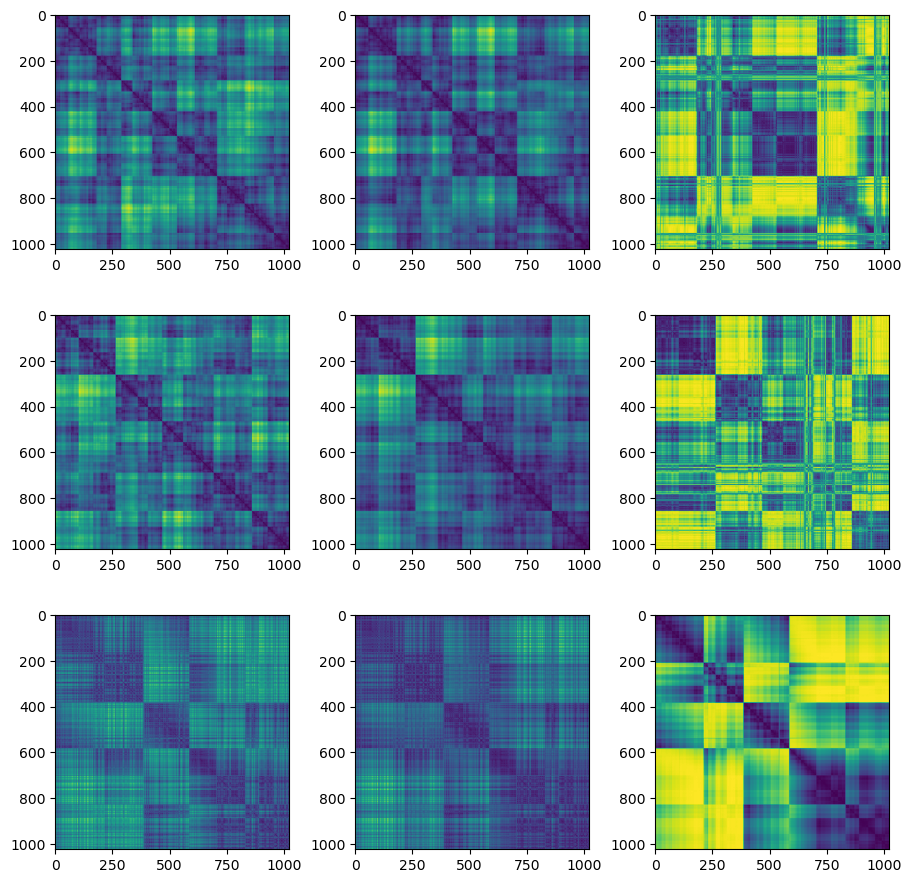

In [98]:
fig, ax = plt.subplots(3,3,figsize=(9,9), layout='constrained')
for ii in range(3):
    for jj in range(3):
        ax[ii,jj].imshow(ser_data[ii][jj])
plt.show()